# **Predictive Modeling for PE, SLE, HPT, and HPTh Using Gene Expression Data**

This notebook performs a comprehensive analysis to build predictive models for Preeclampsia (PE), Systemic Lupus Erythematosus (SLE), Hypertension (HPT), and Hypothyroidism (HPTh) using gene expression data. The workflow includes data preprocessing, handling class imbalance, training multiple machine learning models, hyperparameter tuning, and ensemble modeling with a stacking classifier. The goal is to distinguish between disease states (PE, SLE, HPT, HPTh, and healthy controls) and evaluate model performance.

### **1. Import Libraries**

The following libraries are imported for data manipulation, visualization, machine learning, and performance evaluation.

In [1]:
# Import necessary libraries
import joblib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import StackingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

### **2. Suppress Warnings**

Warnings are suppressed to keep the output clean.

In [2]:
import warnings
warnings.filterwarnings("ignore")

### **3. Load Datasets**

Four datasets are loaded:

- **clean_PE_counts.csv:** Gene expression data for Preeclampsia (PE).

- **clean_SLE_counts.csv:** Gene expression data for Systemic Lupus Erythematosus (SLE).

- **clean_HPT_counts.csv:** Gene expression data for Hypertension (HPT).

- **clean_HPTh_counts.csv:** Gene expression data for Hypothyroidism (HPTh).

Additionally, a list of common genes identified from biological analysis is loaded (assumed to be in common_gene_pe_sle_hpt_hpth.xlsx).

In [3]:
# Load the datasets
pe_data = pd.read_csv('clean_data/clean_PE_counts.csv')
sle_data = pd.read_csv('clean_data/clean_SLE_counts.csv')
hpt_data = pd.read_csv('clean_data/clean_HPT_counts.csv')
hpth_data = pd.read_csv('clean_data/clean_HPTh_counts.csv')
common_genes_data = pd.read_excel('clean_data/common_large_gene_pe_sle_hpt_hpth.xlsx')

### **4. Inspect Datasets**

The first few rows of each dataset are displayed to understand their structure.

In [4]:
pe_data.head()

,GSM,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,...,OR11K1P,MIR548AH,MYOCOS,MIR522,MIR6715B,MIR3116-2,MIR3202-2,HSFX3,MIR4481,pe_label
0,GSM4458410,247,10,296,504,123,14,44,990,352,...,0,0,102,0,0,0,0,2,0,1
1,GSM4458411,273,14,277,335,119,20,156,579,283,...,0,0,39,0,0,0,0,0,0,1
2,GSM4458412,213,25,271,298,81,50,120,818,267,...,0,0,55,0,0,0,0,2,0,1
3,GSM4458413,185,14,248,412,72,49,93,892,458,...,0,0,48,0,0,0,0,2,0,1
4,GSM4458414,330,45,278,143,54,30,43,661,238,...,0,0,31,0,0,0,0,3,0,1


In [5]:
sle_data.head()

,GSM,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,...,MIR6830,TCF20.7,MIR548AH,MIR522,MIR6715B,MIR3116-2,MIR3202-2,HSFX3,MIR4481,sle_label
0,GSM2971168,17.8011,0.0,721.5966,797.9403,805.6276,2.9582,8.0294,355.2471,605.0066,...,0.0,285.8661,0.0000,0.0,0.0,0.0,0.0,0.9984,0.0,0
1,GSM2971169,12.3615,0.0,583.1102,607.0793,634.0865,7.9746,8.0656,272.5566,349.9753,...,0.0,211.9029,0.0000,0.0,0.0,0.0,0.0,1.9831,0.0,0
2,GSM2971170,17.0541,0.0,733.4741,802.6047,608.7467,34.8095,34.3673,412.6358,525.4825,...,0.0,261.3906,0.0000,0.0,0.0,0.0,0.0,3.5228,0.0,0
3,GSM2971171,13.1670,0.0,713.5178,934.9810,693.0651,26.9437,18.0551,397.4186,479.2508,...,0.0,228.0545,0.0000,0.0,0.0,0.0,0.0,7.0343,0.0,0
4,GSM2971172,5.3646,0.0,582.8138,652.5494,671.3984,13.0226,13.0834,300.0774,326.2791,...,0.0,182.2892,1.2763,0.0,0.0,0.0,0.0,1.9835,0.0,0


In [6]:
hpt_data.head()

,GSM,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,...,OR11K1P,MIR548AH,MYOCOS,MIR522,MIR6715B,MIR3116-2,MIR3202-2,HSFX3,MIR4481,hpt_label
0,GSM3417066,61,0,159,52,7,28,260,242,178,...,0,0,2,0,0,0,0,0,0,0
1,GSM3417067,81,2,171,70,26,54,476,349,361,...,0,0,0,0,0,0,0,0,0,0
2,GSM3417068,77,0,140,57,6,37,272,306,207,...,0,0,0,0,0,0,0,0,0,0
3,GSM3417069,59,1,87,38,6,38,145,231,96,...,0,0,2,0,0,0,0,0,0,0
4,GSM3417070,80,1,161,61,20,68,530,194,180,...,0,0,8,0,0,0,0,0,0,0


In [7]:
hpth_data.head()

,GSM,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,...,MIR6830,TCF20.7,MIR548AH,MIR522,MIR6715B,MIR3116-2,MIR3202-2,HSFX3,MIR4481,hpth_label
0,GSM4432626,14,0,1150,428,178,8478,126,439,610,...,0,28,0,0,0,0,0,0,0,0
1,GSM4432627,2,0,361,88,25,1902,35,64,145,...,0,4,0,0,0,0,0,0,0,0
2,GSM4432628,2,0,298,125,64,4143,40,165,292,...,0,10,0,0,0,0,0,0,0,0
3,GSM4432629,0,0,961,260,117,9348,6,340,725,...,0,11,0,0,0,0,0,1,0,0
4,GSM4432630,1,0,689,159,125,7086,62,306,1380,...,0,12,0,0,0,0,0,0,0,0


In [8]:
common_genes_data.head()

,Gene,logFC,padj
0,SCARA5,2.656901,4.210000e-11
1,PLEKHA5,1.283696,1.050000e-08
2,TACC1,1.117781,9.640000e-07
3,KCNIP2,1.552894,1.700000e-08
4,RPL37A,1.841197,3.000000e-08


### **5. Dataset Statistics**

The number of genes and common genes across datasets is calculated.

In [9]:
print("Number of genes in PE dataset:", pe_data.shape[1])
print("Number of genes in SLE dataset:", sle_data.shape[1])
print("Number of genes in HPT dataset:", hpt_data.shape[1])
print("Number of genes in HPTh dataset:", hpth_data.shape[1])
print("Number of total common genes across datasets:", len(set(pe_data.columns[1:]) & set(sle_data.columns[1:]) & set(hpt_data.columns[1:]) & set(hpth_data.columns[1:])))
print("Number of common genes from Biological Analysis:", common_genes_data.shape[0])

Number of genes in PE dataset: 35415
Number of genes in SLE dataset: 28091
Number of genes in HPT dataset: 35415
Number of genes in HPTh dataset: 28127
Number of total common genes across datasets: 24853
Number of common genes from Biological Analysis: 88


### **6. Identify Common Genes**

The genes present in PE, SLE, HPT, HPTh, and the biological analysis are identified, and duplicates are removed.

In [10]:
# Find the genes of PE, SLE, HPT, HPTh, and the common genes
pe_genes = pe_data.columns[1:]
sle_genes = sle_data.columns[1:]
hpt_genes = hpt_data.columns[1:]
hpth_genes = hpth_data.columns[1:]
common_genes = common_genes_data['Gene'].values.tolist()
print("Number of common genes:", len(common_genes))

# Eliminate the genes that are duplicated in common genes
common_genes_clean = set(common_genes)
print("Number of unique common genes:", len(set(common_genes_clean)))

Number of common genes: 88
Number of unique common genes: 88


### **7. Verify Common Genes in Datasets**

The presence of common genes in all four datasets is verified.

In [11]:
# Check if the common genes are present in all datasets
pe_common = [gene for gene in common_genes if gene in pe_genes]
sle_common = [gene for gene in common_genes if gene in sle_genes]
hpt_common = [gene for gene in common_genes if gene in hpt_genes]
hpth_common = [gene for gene in common_genes if gene in hpth_genes]
print("Number of common genes in PE dataset:", len(pe_common))
print("Number of common genes in SLE dataset:", len(sle_common))
print("Number of common genes in HPT dataset:", len(hpt_common))
print("Number of common genes in HPTh dataset:", len(hpth_common))

Number of common genes in PE dataset: 87
Number of common genes in SLE dataset: 86
Number of common genes in HPT dataset: 87
Number of common genes in HPTh dataset: 86


### **8. Identify Missing Genes**

Genes listed as common but missing from any dataset are printed.

In [12]:
# Print the genes that are not found in each dataset
missing_pe = set(common_genes) - set(pe_genes)
print("Genes not found in PE dataset:")
for gene in missing_pe:
    print(gene)
missing_sle = set(common_genes) - set(sle_genes)
print("\nGenes not found in SLE dataset:")
for gene in missing_sle:
    print(gene)
missing_hpt = set(common_genes) - set(hpt_genes)
print("\nGenes not found in HPT dataset:")
for gene in missing_hpt:
    print(gene)
missing_hpth = set(common_genes) - set(hpth_genes)
print("\nGenes not found in HPTh dataset:")
for gene in missing_hpth:
    print(gene)

Genes not found in PE dataset:
IGLJ3

Genes not found in SLE dataset:
IGKC
IGLJ3

Genes not found in HPT dataset:
IGLJ3

Genes not found in HPTh dataset:
IGKC
IGLJ3


### **9. Find Exact Common Genes**

The exact matches of common genes present in all datasets and the biological analysis are identified.

In [13]:
# Find exact matches of common genes in PE, SLE, HPT, HPTh, and common genes
common_genes_all = list(set(pe_genes) & set(sle_genes) & set(hpt_genes) & set(hpth_genes) & set(common_genes))
print("Number of exact matches of common genes in PE, SLE, HPT, HPTh, and common genes:", len(common_genes_all))

Number of exact matches of common genes in PE, SLE, HPT, HPTh, and common genes: 86


### **10. Filter Datasets**

The PE, SLE, HPT, and HPTh datasets are filtered to include only the common genes, and labels are added.

In [14]:
# Filter datasets to only include common genes
pe_data_common = pe_data[common_genes_all]
sle_data_common = sle_data[common_genes_all]
hpt_data_common = hpt_data[common_genes_all]
hpth_data_common = hpth_data[common_genes_all]

# Add labels to the datasets
pe_data_common['label'] = pe_data['pe_label']
sle_data_common['label'] = sle_data['sle_label']
hpt_data_common['label'] = hpt_data['hpt_label']
hpth_data_common['label'] = hpth_data['hpth_label']

print("PE dataset shape after filtering:", pe_data_common.shape)
print("SLE dataset shape after filtering:", sle_data_common.shape)
print("HPT dataset shape after filtering:", hpt_data_common.shape)
print("HPTh dataset shape after filtering:", hpth_data_common.shape)

PE dataset shape after filtering: (83, 87)
SLE dataset shape after filtering: (77, 87)
HPT dataset shape after filtering: (30, 87)
HPTh dataset shape after filtering: (9, 87)


### **11. Merge Datasets**

The filtered datasets are merged on common genes, and labels are combined.

In [15]:
# Fix the labels
sle_data_common['label'] = sle_data_common['label'].replace(1, 2)
hpt_data_common['label'] = hpt_data_common['label'].replace(1, 3)
hpth_data_common['label'] = hpth_data_common['label'].replace(1, 4)

# Combine the datasets
merged_data = pd.concat([pe_data_common, sle_data_common, hpt_data_common, hpth_data_common], ignore_index=True)
print("Combined dataset shape:", merged_data.shape)


# Convert labels to integers
merged_data['label'] = merged_data['label'].astype(int)

# Save the merged dataset
merged_data.to_csv('clean_data/merged_pe_sle_hpt_hpth_large_data.csv', index=False)

Combined dataset shape: (199, 87)


### **12. Inspect Merged Dataset**

The first few rows of the merged dataset are displayed.

In [16]:
merged_data.head()

,PRMT5,RAB32,LPL,PDK4,STAG2,TFRC,PID1,JCHAIN,CBX1,IL21R,...,P2RY14,SCML4,ATP6V1C1,ITSN1,ITGB2,SGMS2,CUTC,HBB,HES1,label
0,599.0,23.0,2225.0,1228.0,1625.0,24789.0,366.0,0.0,449.0,0.0,...,95.0,0.0,1130.0,1075.0,269.0,795.0,83.0,961.0,581.0,1
1,599.0,25.0,1718.0,1085.0,1315.0,11953.0,273.0,0.0,413.0,12.0,...,148.0,0.0,821.0,705.0,242.0,223.0,85.0,1775.0,776.0,1
2,649.0,20.0,3593.0,940.0,1154.0,11993.0,207.0,2.0,397.0,6.0,...,99.0,1.0,541.0,933.0,269.0,423.0,117.0,1204.0,898.0,1
3,565.0,15.0,272.0,1131.0,1448.0,7821.0,333.0,0.0,356.0,4.0,...,104.0,0.0,1099.0,881.0,262.0,589.0,101.0,1557.0,929.0,1
4,780.0,19.0,674.0,1548.0,995.0,6527.0,636.0,0.0,248.0,2.0,...,48.0,0.0,760.0,513.0,333.0,300.0,113.0,1859.0,586.0,1


### **13. Visualize Label Distribution**

A bar plot shows the distribution of labels in the merged dataset.

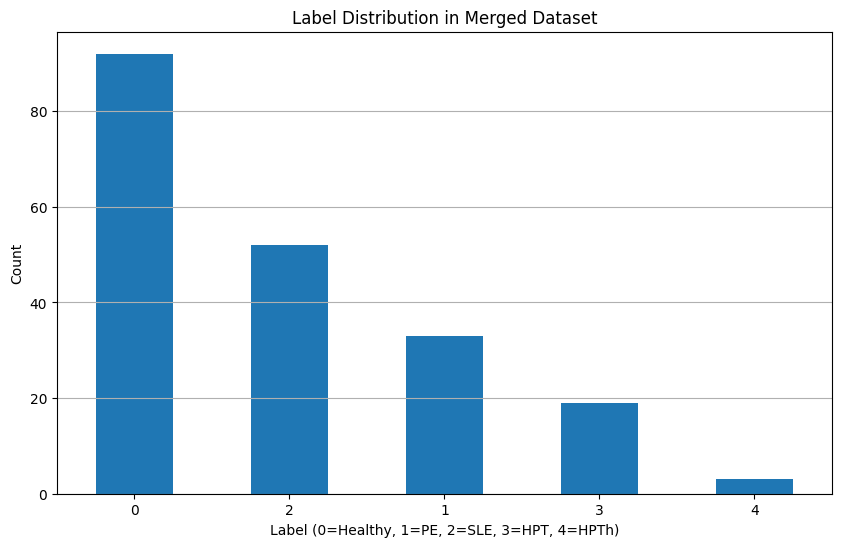

In [17]:
# Plot the distribution of labels with bar plot
plt.figure(figsize=(10, 6))
merged_data['label'].value_counts().plot(kind='bar')
plt.title('Label Distribution in Merged Dataset')
plt.xlabel('Label (0=Healthy, 1=PE, 2=SLE, 3=HPT, 4=HPTh)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

### **14. Split Features and Labels**

The dataset is split into features (X) and labels (y).

In [18]:
# Split the merged dataset into features and labels
X = merged_data.drop(columns=['label'])
y = merged_data['label']
print("Features shape:", X.shape)
print("Labels shape:", y.shape)

Features shape: (199, 86)
Labels shape: (199,)


### **15. Scale Features**

Features are standardized using StandardScaler.

In [19]:
# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("Scaled features shape:", X_scaled.shape)

Scaled features shape: (199, 86)


### **16. Handle Class Imbalance with SMOTE**

SMOTE is used to upsample the minority class, and the label distribution is visualized.

Resampled features shape: (460, 86)
Resampled labels shape: (460,)


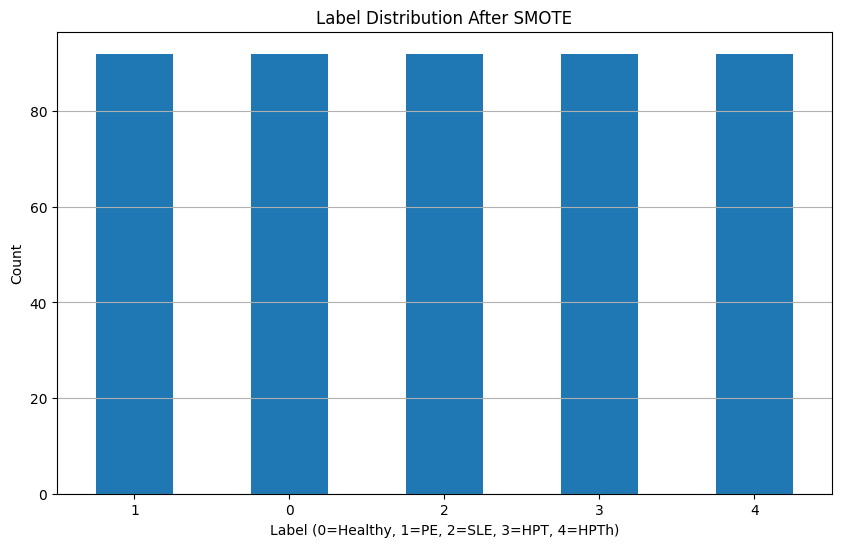

In [20]:
# Upsample the minority class using SMOTE
smote = SMOTE(random_state=42, k_neighbors=2)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)
print("Resampled features shape:", X_resampled.shape)
print("Resampled labels shape:", y_resampled.shape)

# Check the distribution of labels after SMOTE
plt.figure(figsize=(10, 6))
y_resampled.value_counts().plot(kind='bar')
plt.title('Label Distribution After SMOTE')
plt.xlabel('Label (0=Healthy, 1=PE, 2=SLE, 3=HPT, 4=HPTh)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

### **17. Split Training and Testing Sets**

The resampled dataset is split into training (80%) and testing (20%) sets.

In [21]:
# Split the resampled dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
print("Training features shape:", X_train.shape)
print("Training labels shape:", y_train.shape)
print("Testing features shape:", X_test.shape)
print("Testing labels shape:", y_test.shape)

Training features shape: (368, 86)
Training labels shape: (368,)
Testing features shape: (92, 86)
Testing labels shape: (92,)


### **18. Train and Evaluate Base Models**

A dictionary of seven ML models is defined, trained, and evaluated on the test set. Performance metrics include accuracy, precision, recall, F1-score, and ROC AUC.

In [22]:
# Define a dictionary of models to train
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'SVM': SVC(probability=True),
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'LightGBM': LGBMClassifier(verbose=-1)
}

results = []  # List to store performance metrics for each model

# Train each model and evaluate its performance
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
    
    # Calculate ROC AUC using predict_proba if available
    if hasattr(model, "predict_proba"):
        y_proba_full = model.predict_proba(X_test)
        n_classes = len(np.unique(y_test))
        if n_classes == 2:
            # For binary classification, use the positive class probabilities
            y_proba = y_proba_full[:, 1]
            roc_auc = roc_auc_score(y_test, y_proba)
        else:
            # For multiclass, pass the full probability array with multi_class option
            roc_auc = roc_auc_score(y_test, y_proba_full, multi_class='ovr')
    else:
        roc_auc = np.nan

    # Print performance metrics
    print(f"Model: {name}")
    print(f"  Accuracy : {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall   : {recall:.4f}")
    print(f"  F1 Score : {f1:.4f}")
    if not np.isnan(roc_auc):
        print(f"  ROC AUC  : {roc_auc:.4f}")
    else:
        print("  ROC AUC  : Not available")
    print("-" * 40)

    # Append results to list
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc
    })

# Store the results in a dataframe and print
results_df = pd.DataFrame(results)
print("Summary of model performance:")
print(results_df)

# Save the model results
results_df.to_csv('performances/pe_sle_hpt_hpth_large_base_predictive_model_performance.csv', index=False)

Model: Logistic Regression
  Accuracy : 0.9348
  Precision: 0.9459
  Recall   : 0.9354
  F1 Score : 0.9374
  ROC AUC  : 0.9721
----------------------------------------
Model: SVM
  Accuracy : 0.9565
  Precision: 0.9624
  Recall   : 0.9576
  F1 Score : 0.9592
  ROC AUC  : 0.9920
----------------------------------------
Model: KNN
  Accuracy : 0.9348
  Precision: 0.9469
  Recall   : 0.9302
  F1 Score : 0.9346
  ROC AUC  : 0.9840
----------------------------------------
Model: Random Forest
  Accuracy : 0.9565
  Precision: 0.9624
  Recall   : 0.9576
  F1 Score : 0.9592
  ROC AUC  : 0.9963
----------------------------------------
Model: Gradient Boosting
  Accuracy : 0.9674
  Precision: 0.9715
  Recall   : 0.9687
  F1 Score : 0.9698
  ROC AUC  : 0.9929
----------------------------------------
Model: XGBoost
  Accuracy : 0.9457
  Precision: 0.9540
  Recall   : 0.9465
  F1 Score : 0.9484
  ROC AUC  : 0.9973
----------------------------------------
Model: LightGBM
  Accuracy : 0.9565
  Precis

### **19. Visualize Base Model Performance**

A bar plot compares the performance metrics across models.

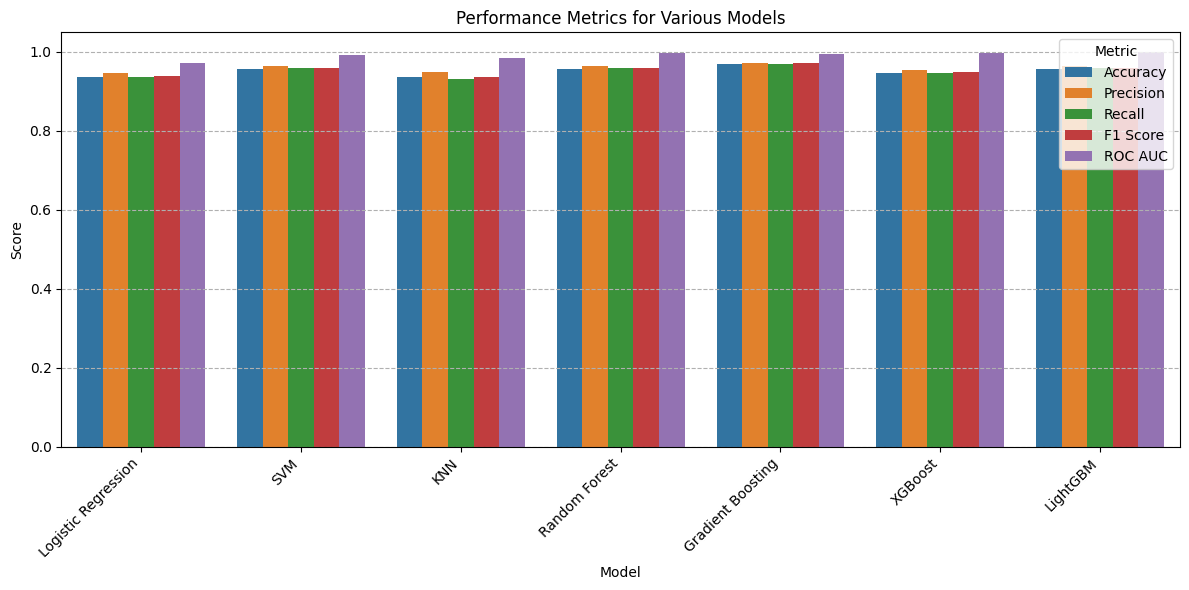

In [23]:
# Plot the performance metrics
# Melt the results_df so that each row represents a metric score for a given model
results_melted = results_df.melt(id_vars='Model', var_name='Metric', value_name='Score')

plt.figure(figsize=(12, 6))
sns.barplot(data=results_melted, x='Model', y='Score', hue='Metric')
plt.title("Performance Metrics for Various Models")
plt.ylabel("Score")
plt.xticks(rotation=45, ha='right')
plt.grid(True, axis='y', linestyle='--')
plt.tight_layout()

# Save the figure
plt.savefig('figures/pe_sle_hpt_hpth_large_base_predictive_model_performance.png')
# Show the plot
plt.show()

### **20. Hyperparameter Tuning**

Hyperparameter tuning is performed for each model using GridSearchCV with F1-macro as the scoring metric.

In [24]:
# Hyperparameter tuning for all models for multiclass classification

# Define the hyperparameter grid for each model
param_grids = {
    'Logistic Regression': {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'penalty': ['l2'],
        'solver': ['lbfgs']
    },
    'SVM': {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'kernel': ['linear', 'rbf', 'poly']
    },
    'KNN': {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    },
    'Gradient Boosting': {
        'n_estimators': [50, 100],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5]
    },
    'XGBoost': {
        'n_estimators': [50, 100],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5]
    },
    'LightGBM': {
        'n_estimators': [50, 100],
        'learning_rate': [0.01, 0.1],
        'num_leaves': [31, 63]
    }
}

# Initialize a dictionary to store the best models and their scores
best_models = {}

# Iterate through each model and perform hyperparameter tuning
for name, model in models.items():
    print(f"Tuning hyperparameters for {name}...")
    param_grid = param_grids[name]
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    # Get the best model and its score
    best_model = grid_search.best_estimator_
    best_score = grid_search.best_score_
    
    # Store the best model and its score
    best_models[name] = {
        'model': best_model,
        'score': best_score
    }
    
    print(f"Best parameters for {name}: {grid_search.best_params_}")
    print(f"Best F1 Score (macro) for {name}: {best_score:.4f}")
    print("-" * 40)

# Print the best models and their scores
print("\n\nBest models and their scores:")
for name, info in best_models.items():
    print(f"{name}: Best F1 Score (macro) = {info['score']:.4f}")
    print(f"Best Parameters: {info['model'].get_params()}")
    print("-" * 40)

Tuning hyperparameters for Logistic Regression...
Best parameters for Logistic Regression: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Best F1 Score (macro) for Logistic Regression: 0.9606
----------------------------------------
Tuning hyperparameters for SVM...
Best parameters for SVM: {'C': 10, 'kernel': 'linear'}
Best F1 Score (macro) for SVM: 0.9610
----------------------------------------
Tuning hyperparameters for KNN...
Best parameters for KNN: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Best F1 Score (macro) for KNN: 0.9316
----------------------------------------
Tuning hyperparameters for Random Forest...
Best parameters for Random Forest: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best F1 Score (macro) for Random Forest: 0.9579
----------------------------------------
Tuning hyperparameters for Gradient Boosting...
Best parameters for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 1

/home/sajid/anaconda3/envs/dsenv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:10:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/sajid/anaconda3/envs/dsenv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:10:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/sajid/anaconda3/envs/dsenv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:10:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/sajid/anaconda3/envs/dsenv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:10:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/sajid/

Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Best F1 Score (macro) for XGBoost: 0.9438
----------------------------------------
Tuning hyperparameters for LightGBM...


/home/sajid/anaconda3/envs/dsenv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/sajid/anaconda3/envs/dsenv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/sajid/anaconda3/envs/dsenv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/sajid/anaconda3/envs/dsenv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/sajid/anaconda3/envs/dsenv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LG

Best parameters for LightGBM: {'learning_rate': 0.1, 'n_estimators': 100, 'num_leaves': 31}
Best F1 Score (macro) for LightGBM: 0.9560
----------------------------------------


Best models and their scores:
Logistic Regression: Best F1 Score (macro) = 0.9606
Best Parameters: {'C': 10, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1000, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
----------------------------------------
SVM: Best F1 Score (macro) = 0.9610
Best Parameters: {'C': 10, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': -1, 'probability': True, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
----------------------------------------
KNN: Best F1 Score (macr

### **21. Evaluate Tuned Models**

The best models are evaluated on the test set, and results are saved.

In [25]:
# Evaluate the best model on the test set and store the results in a dataframe

best_model_results = []
for name, info in best_models.items():
    model = info['model']
    y_pred = model.predict(X_test)
    
    # Calculate performance metrics using macro-average for multiclass classification
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
    
    # Calculate ROC AUC using predict_proba if available
    if hasattr(model, "predict_proba"):
        y_proba_full = model.predict_proba(X_test)
        n_classes = len(np.unique(y_test))
        if n_classes == 2:
            y_proba = y_proba_full[:, 1]
            roc_auc = roc_auc_score(y_test, y_proba)
        else:
            roc_auc = roc_auc_score(y_test, y_proba_full, multi_class='ovr')
    else:
        roc_auc = np.nan

    # Append results to list
    best_model_results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc
    })

# Store the results in a dataframe and print
best_model_results_df = pd.DataFrame(best_model_results)
print("Summary of best model performance:")
print(best_model_results_df)

# Save the best model results
best_model_results_df.to_csv('performances/pe_sle_hpt_hpth__large_hyperparameter_tuned_predictive_model_performance.csv', index=False)

Summary of best model performance:
                 Model  Accuracy  Precision    Recall  F1 Score   ROC AUC
0  Logistic Regression  0.934783   0.945899  0.935354  0.937416  0.971786
1                  SVM  0.967391   0.976490  0.966667  0.969681  0.974245
2                  KNN  0.956522   0.962416  0.957576  0.959216  0.985323
3        Random Forest  0.967391   0.971452  0.968687  0.969845  0.997234
4    Gradient Boosting  0.967391   0.971452  0.968687  0.969845  0.993815
5              XGBoost  0.945652   0.953974  0.946465  0.948384  0.998300
6             LightGBM  0.956522   0.962416  0.957576  0.959216  0.998580


### **22. Visualize Tuned Model Performance**

A bar plot compares the performance metrics of the tuned models.

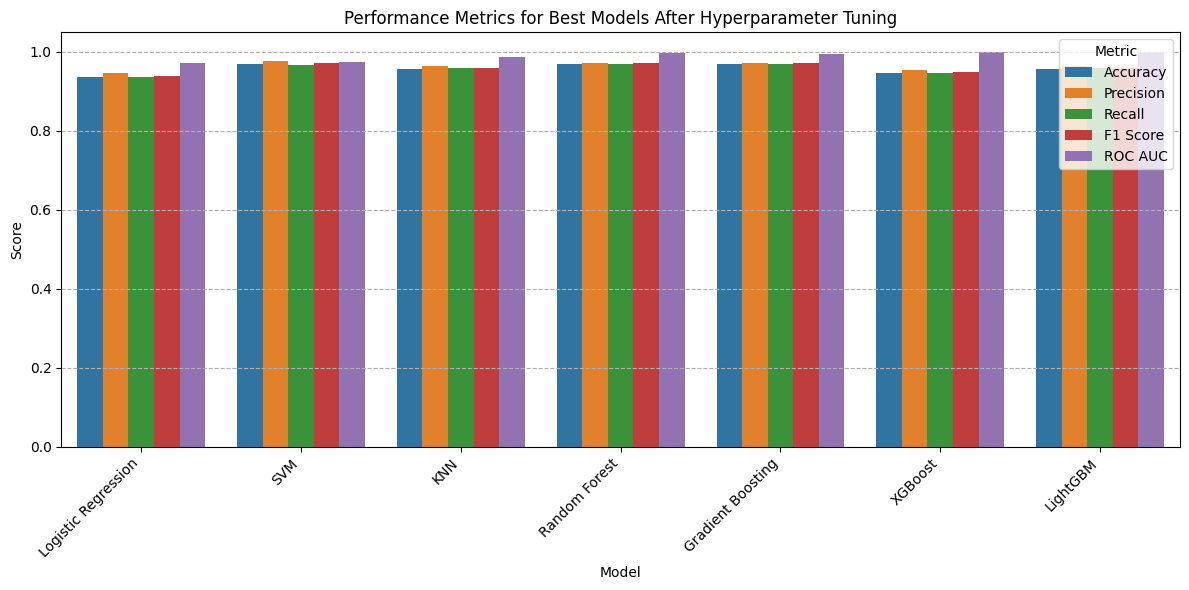

In [26]:
# Plot the best models and their scores after hyperparameter tuning
plt.figure(figsize=(12, 6))
best_model_results_melted = best_model_results_df.melt(id_vars='Model', var_name='Metric', value_name='Score')
sns.barplot(data=best_model_results_melted, x='Model', y='Score', hue='Metric')
plt.title("Performance Metrics for Best Models After Hyperparameter Tuning")
plt.ylabel("Score")
plt.xticks(rotation=45, ha='right')
plt.grid(True, axis='y', linestyle='--')
plt.tight_layout()

# Save the figure
plt.savefig('figures/pe_sle_hpt_hpth_large_hyperparameter_tuned_predictive_model_performance.png')
# Show the plot
plt.show()

### **23. Stacking Classifier**

A stacking classifier is created using the five best models, with LogisticRegression as the final estimator.

In [27]:
# Create a Stacking Classifier with the 5 best models
base_models = [
    ('Gradient Boosting', best_models['Gradient Boosting']['model']),
    ('SVM', best_models['SVM']['model']),
    ('Random Forest', best_models['Random Forest']['model']),
    ('XGBoost', best_models['XGBoost']['model']),
    ('LightGBM', best_models['LightGBM']['model'])
]

stacking_model = StackingClassifier(
    estimators=base_models,
    final_estimator=LogisticRegression(max_iter=1000),
    cv=5
)

# Train the stacking model
stacking_model.fit(X_train, y_train)

# Evaluate the stacking model on the test set
y_pred_stacking = stacking_model.predict(X_test)

# Calculate performance metrics using macro-average for multiclass classification
accuracy_stacking = accuracy_score(y_test, y_pred_stacking)
precision_stacking = precision_score(y_test, y_pred_stacking, average='macro', zero_division=0)
recall_stacking = recall_score(y_test, y_pred_stacking, average='macro', zero_division=0)
f1_stacking = f1_score(y_test, y_pred_stacking, average='macro', zero_division=0)

# Calculate ROC AUC using predict_proba if available
if hasattr(stacking_model, "predict_proba"):
    y_proba_full = stacking_model.predict_proba(X_test)
    n_classes = len(np.unique(y_test))
    if n_classes == 2:
        # For binary, use the positive class probabilities
        y_proba = y_proba_full[:, 1]
        roc_auc_stacking = roc_auc_score(y_test, y_proba)
    else:
        # For multiclass, use full array and specify multi_class
        roc_auc_stacking = roc_auc_score(y_test, y_proba_full, multi_class='ovr')
else:
    roc_auc_stacking = np.nan

# Print performance metrics for the stacking model
print(f"Stacking Model:")
print(f"  Accuracy : {accuracy_stacking:.4f}")
print(f"  Precision: {precision_stacking:.4f}")
print(f"  Recall   : {recall_stacking:.4f}")
print(f"  F1 Score : {f1_stacking:.4f}")
if not np.isnan(roc_auc_stacking):
    print(f"  ROC AUC  : {roc_auc_stacking:.4f}")
else:
    print("  ROC AUC  : Not available")
print("-" * 40)

# Save the stacking model
joblib.dump(stacking_model, 'models/pe_sle_hpt_hpth_large_stacking_model.pkl')

Stacking Model:
  Accuracy : 0.9565
  Precision: 0.9624
  Recall   : 0.9576
  F1 Score : 0.9592
  ROC AUC  : 0.9949
----------------------------------------


['models/pe_sle_hpt_hpth_large_stacking_model.pkl']